In [10]:
#ABHINAND SATISH
#worked with Thompson and Piccoli


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd



In [11]:
# -----------------------------
# Constants and decay data
# -----------------------------
half_lives = {
    "Ra226": 4.97664e10,   # sec
    "Rn222": 330048,       # sec
    "Po218": 186           # sec
}
lmbda = {iso: np.log(2) / T for iso, T in half_lives.items()}

NA = 6.022e23
molar_mass_Ra226 = 226.0  # g/mol

# Initial condition: 1 g Ra-226, daughters = 0
N0_Ra = (1.0 / molar_mass_Ra226) * NA
N0 = [N0_Ra, 0.0, 0.0]  # [Ra-226, Rn-222, Po-218]

# Extra production/burnup terms (atoms/sec per gram Ra)
burnup_terms = {
    "Ra226": -1e13,
    "Rn222": +1e9,
    "Po218": +1e3
}


In [12]:
# Time grid: 0..40 days
t_days = np.arange(0, 40.01, 0.01)
t = t_days * 24 * 3600

# -----------------------------
# Differential equations
# -----------------------------
def decay_chain(N, tsec):
    N_Ra, N_Rn, N_Po = N
    Ra_mass_factor = N_Ra / N0_Ra
    burn_Ra = burnup_terms["Ra226"] * Ra_mass_factor
    prod_Rn = burnup_terms["Rn222"] * Ra_mass_factor
    prod_Po = burnup_terms["Po218"] * Ra_mass_factor

    dN_Ra = -lmbda["Ra226"] * N_Ra + burn_Ra
    dN_Rn = (lmbda["Ra226"] * N_Ra) - (lmbda["Rn222"] * N_Rn) + prod_Rn
    dN_Po = (lmbda["Rn222"] * N_Rn) - (lmbda["Po218"] * N_Po) + prod_Po
    return [dN_Ra, dN_Rn, dN_Po]

# -----------------------------
# Scenario 1: closed system, vent at 40 d
# -----------------------------
N_sol1 = odeint(decay_chain, N0, t)
rn_released_s1 = N_sol1[-1, 1]  # all Rn present at 40 d is vented
N_sol1[-1, 1] = 0.0             # drop Rn-222
N_sol1[-1, 2] = 0.0             # drop Po-218

# -----------------------------
# Scenario 2: vent Rn every 10 days
# -----------------------------
N_sol2 = [N0[:]]
N_current = N0[:]
rn_released_s2 = 0.0
for i in range(len(t_days)-1):
    t_span = np.linspace(t[i], t[i+1], 50)
    sol = odeint(decay_chain, N_current, t_span)
    N_current = sol[-1]

    if (t_days[i+1] % 10 == 0):
        rn_released_s2 += N_current[1]  # accumulate released Rn
        N_current[1] = 0.0              # vent
    N_sol2.append(N_current)
N_sol2 = np.array(N_sol2)

# -----------------------------
# Activities
# -----------------------------
def activity(N, iso):
    return lmbda[iso] * N
A_sol1 = {iso: activity(N_sol1[:, i], iso) for i, iso in enumerate(["Ra226", "Rn222", "Po218"])}
A_sol2 = {iso: activity(N_sol2[:, i], iso) for i, iso in enumerate(["Ra226", "Rn222", "Po218"])}


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8640000000000D+06   r2 =  0.3213329889655D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8640000000000D+06   r2 =  0.3213329889655D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8640000000000D+06   r2 =  0.3213329889655D-10
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8640000000000D+06   r2 =  0.3213329889655D-10
 lsoda--  warning..internal t (=r1) 

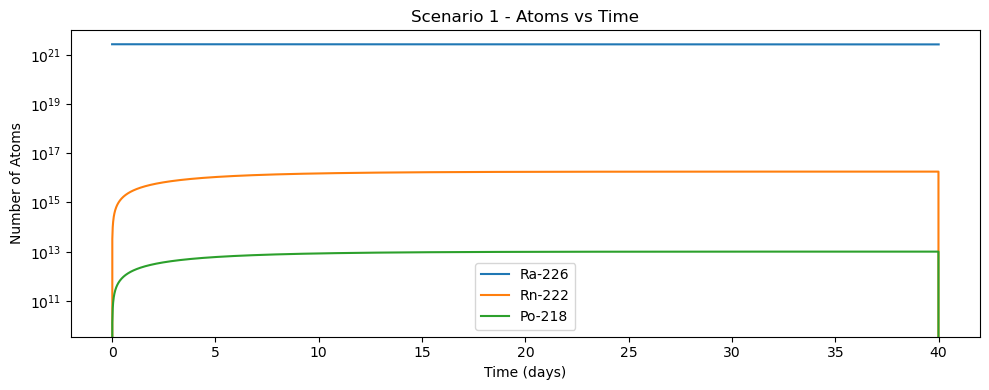

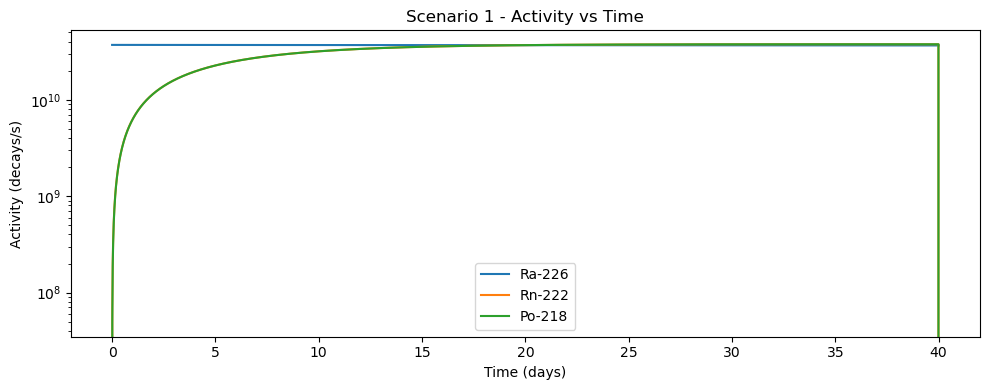

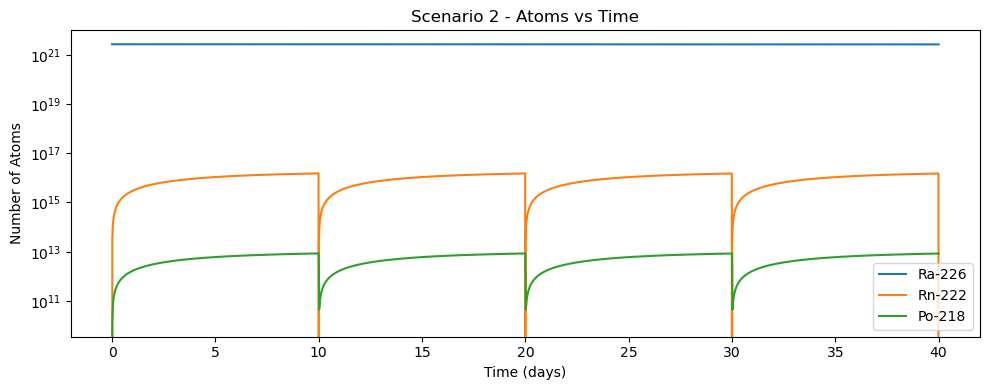

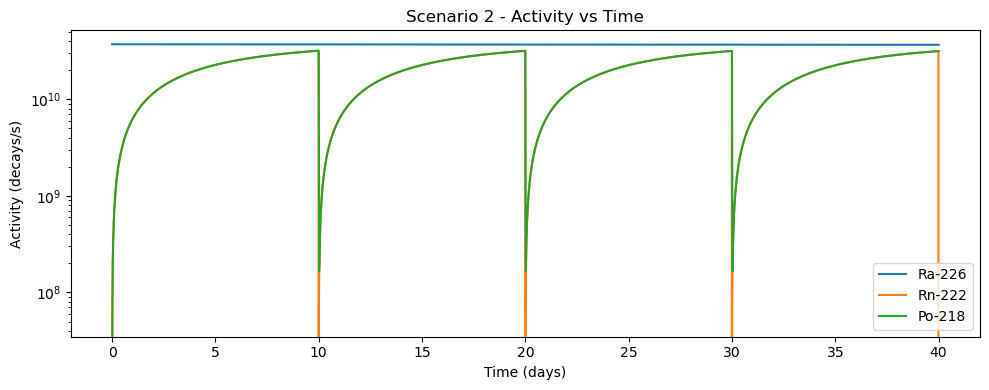

Final results - Scenario 1
Isotope        Atoms  Activity [Bq]
 Ra-226 2.630138e+21   3.663261e+10
 Rn-222 0.000000e+00   0.000000e+00
 Po-218 0.000000e+00   0.000000e+00

Final results - Scenario 2
Isotope        Atoms  Activity [Bq]
 Ra-226 2.630138e+21   3.663261e+10
 Rn-222 0.000000e+00   0.000000e+00
 Po-218 8.459180e+12   3.152396e+10

=== Rn-222 Released ===
Scenario 1 (vent at 40 d): 1.793e+16 atoms
Scenario 2 (vents at 10,20,30,40 d): 6.034e+16 atoms
Difference (S2 - S1): 4.241e+16 atoms

Total fraction of Ra-226 burned (burn term only): 1.297e-02


In [13]:

# -----------------------------
# Plotting
# -----------------------------
def plot_results(t_days, N_sol, A_sol, scenario):
    plt.figure(figsize=(10, 4))
    plt.yscale("log")
    plt.plot(t_days, N_sol[:, 0], label="Ra-226")
    plt.plot(t_days, N_sol[:, 1], label="Rn-222")
    plt.plot(t_days, N_sol[:, 2], label="Po-218")
    plt.xlabel("Time (days)")
    plt.ylabel("Number of Atoms")
    plt.title(f"Scenario {scenario} - Atoms vs Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.yscale("log")
    plt.plot(t_days, A_sol["Ra226"], label="Ra-226")
    plt.plot(t_days, A_sol["Rn222"], label="Rn-222")
    plt.plot(t_days, A_sol["Po218"], label="Po-218")
    plt.xlabel("Time (days)")
    plt.ylabel("Activity (decays/s)")
    plt.title(f"Scenario {scenario} - Activity vs Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_results(t_days, N_sol1, A_sol1, 1)
plot_results(t_days, N_sol2, A_sol2, 2)

# -----------------------------
# Final tables
# -----------------------------
final1 = {
    "Isotope": ["Ra-226", "Rn-222", "Po-218"],
    "Atoms": N_sol1[-1],
    "Activity [Bq]": [A_sol1[iso][-1] for iso in ["Ra226", "Rn222", "Po218"]]
}
final2 = {
    "Isotope": ["Ra-226", "Rn-222", "Po-218"],
    "Atoms": N_sol2[-1],
    "Activity [Bq]": [A_sol2[iso][-1] for iso in ["Ra226", "Rn222", "Po218"]]
}
print("Final results - Scenario 1")
print(pd.DataFrame(final1).to_string(index=False))
print("\nFinal results - Scenario 2")
print(pd.DataFrame(final2).to_string(index=False))

# -----------------------------
# Released Rn summary
# -----------------------------
print("\n=== Rn-222 Released ===")
print(f"Scenario 1 (vent at 40 d): {rn_released_s1:.3e} atoms")
print(f"Scenario 2 (vents at 10,20,30,40 d): {rn_released_s2:.3e} atoms")
print(f"Difference (S2 - S1): {rn_released_s2 - rn_released_s1:.3e} atoms")


#ouptut total fraction of Ra-226 burned but burn term only
total_burned = -burnup_terms["Ra226"] * (t[-1] / N0_Ra)
print(f"\nTotal fraction of Ra-226 burned (burn term only): {total_burned:.3e}")
